### _The aim of this project is to use video game sales data to determine how the popularity of different video game genres has changed over the years so that we can explore what are the kind of games that video game publishers are investing the most in._

---

# Loading Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from pylab import *
from sklearn import linear_model
#!pip install cufflinks
import cufflinks as cf
import plotly
plotly.offline.init_notebook_mode()
cf.go_offline()
import warnings
warnings.filterwarnings('ignore')
import os

sns.reset_defaults()

---

# Loading the Dataset

In [2]:
df = pd.read_csv(r'Video_Game_Sales_as_of_Jan_2017.csv')

df.head(20)
df.shape
df.info()

Name Platform  Year_of_Release  \
0                                     Wii Sports      Wii           2006.0   
1                              Super Mario Bros.      NES           1985.0   
2                                 Mario Kart Wii      Wii           2008.0   
3                              Wii Sports Resort      Wii           2009.0   
4                       Pokemon Red/Pokemon Blue        G           1996.0   
5                                         Tetris        G           1989.0   
6                          New Super Mario Bros.       DS           2006.0   
7                                       Wii Play      Wii           2006.0   
8                      New Super Mario Bros. Wii      Wii           2009.0   
9                                      Duck Hunt      NES           1984.0   
10                                    Nintendogs       DS           2005.0   
11                                 Mario Kart DS       DS           2005.0   
12                   Pokemon Gold/Pokemon Silver        G           1999.0   
13                                       Wii Fit      Wii           2007.0   
14                            Kinect Adventures!     X360           2010.0   
15                                  Wii Fit Plus      Wii           2009.0   
16                            Grand Theft Auto V      PS3           2013.0   
17                 Grand Theft Auto: San Andreas      PS2           2004.0   
18                             Super Mario World     SNES           1990.0   
19  Brain Age: Train Your Brain in Minutes a Day       DS           2005.0   

           Genre               Publisher  NA_Sales  EU_Sales  JP_Sales  \
0         Sports                Nintendo     41.36     28.96      3.77   
1       Platform                Nintendo     29.08      3.58      6.81   
2         Racing                Nintendo     15.68     12.80      3.79   
3         Sports                Nintendo     15.61     10.95      3.28   
4   Role-Playing                Nintendo     11.27      8.89     10.22   
5         Puzzle                Nintendo     23.20      2.26      4.22   
6       Platform                Nintendo     11.28      9.15      6.50   
7           Misc                Nintendo     13.96      9.18      2.93   
8       Platform                Nintendo     14.48      6.95      4.70   
9        Shooter                Nintendo     26.93      0.63      0.28   
10    Simulation                Nintendo      9.05     10.95      1.93   
11        Racing                Nintendo      9.71      7.48      4.13   
12  Role-Playing                Nintendo      9.00      6.18      7.20   
13        Sports                Nintendo      8.92      8.03      3.60   
14          Misc  Microsoft Game Studios     15.02      4.91      0.24   
15        Sports                Nintendo      9.01      8.49      2.53   
16        Action    Take-Two Interactive      7.02      9.14      0.98   
17        Action    Take-Two Interactive      9.43      0.40      0.41   
18      Platform                Nintendo     12.78      3.75      3.54   
19          Misc                Nintendo      4.74      9.20      4.16   

    Other_Sales  Global_Sales  Critic_Score  Critic_Count  User_Score  \
0          8.45         82.54          76.0          51.0         8.0   
1          0.77         40.24           NaN           NaN         NaN   
2          3.29         35.57          82.0          73.0         8.3   
3          2.95         32.78          80.0          73.0         8.0   
4          1.00         31.37           NaN           NaN         NaN   
5          0.58         30.26           NaN           NaN         NaN   
6          2.88         29.81          89.0          65.0         8.5   
7          2.84         28.92          58.0          41.0         6.6   
8          2.25         28.38          87.0          80.0         8.4   
9          0.47         28.31           NaN           NaN         NaN   
10         2.74         24.67           NaN    

(17416, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17416 entries, 0 to 17415
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             17416 non-null  object 
 1   Platform         17416 non-null  object 
 2   Year_of_Release  17408 non-null  float64
 3   Genre            17416 non-null  object 
 4   Publisher        17415 non-null  object 
 5   NA_Sales         17416 non-null  float64
 6   EU_Sales         17416 non-null  float64
 7   JP_Sales         17416 non-null  float64
 8   Other_Sales      17416 non-null  float64
 9   Global_Sales     17416 non-null  float64
 10  Critic_Score     8336 non-null   float64
 11  Critic_Count     8336 non-null   float64
 12  User_Score       7798 non-null   float64
 13  User_Count       7798 non-null   float64
 14  Rating           10252 non-null  object 
dtypes: float64(10), object(5)
memory usage: 2.0+ MB


---

# Cleaning up the Data

In this section we clean up the data to account for the following requirements:

1. First, if there are any records with unknown Release Years, then we would need to omit those records as this incomplete information will affect the correctness of our visualizations.

2. This dataset has records for videogames released till January of 2017 - all entries for the year 2017 will be omitted because the sales are just for the month of January, not the whole year. 

3. The Year_of_Release column has float values for years - this will be changed to integers.

4. Renaming the Genre value 'Platform' to 'Platformer' to avoid confusion with the column of the same name.

    ('Platformers' are a video game genre and subgenre of action games in which the core objective is to move the player character between points in a rendered environment. Platformer games are characterized by their level design featuring uneven terrain and suspended platforms of varying height that requires use of the player character's abilities.)
    
5. Renaming some Platform values to provide clarification.

6. Adding another column to the dataset that includes the launch years for all respective platforms (retrieved from Wikipedia).

7. Some games might have been listed with their Release Year earlier than the Launch Year of their respective platforms - extracting all such games and fixing their dates where possible, dropping the ones where fixing the dates is not possible.


In [3]:
# checking percentage of null values w.r.t. the entire dataset before any data cleanup
df.isnull().mean().sort_values(ascending=False).mul(100).round(2).astype(str) + '%'

User_Score         55.23%
User_Count         55.23%
Critic_Score       52.14%
Critic_Count       52.14%
Rating             41.13%
Year_of_Release     0.05%
Publisher           0.01%
Name                 0.0%
Platform             0.0%
Genre                0.0%
NA_Sales             0.0%
EU_Sales             0.0%
JP_Sales             0.0%
Other_Sales          0.0%
Global_Sales         0.0%
dtype: object

In [4]:
df.shape

# Dropping unneeded columns
df.drop(columns=['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count' , 'Rating'], inplace=True)

# Remove null (NaN) values from Year of Release
df = df[df.Year_of_Release.notnull()]
df.shape

# Omitting video games released in 2017.
df = df.loc[df.Year_of_Release < 2017]
df.shape

# Converting Year_of_Release column to integers
df.Year_of_Release = df['Year_of_Release'].astype(int)
df.head()

# Renaming Genre column value 'Platform' to 'Platformer'
df['Genre'] = df['Genre'].replace({'Platform': 'Platformer'})

# Renaming some Platform values to provide clarification.
df['Platform'] = df['Platform'].replace({'X360': 'Xbox360'})
df['Platform'] = df['Platform'].replace({'X': 'Xbox'})
df['Platform'] = df['Platform'].replace({'G': 'GameBoy'})

(17416, 15)

(17408, 10)

(17403, 10)

Name Platform  Year_of_Release         Genre Publisher  \
0                Wii Sports      Wii             2006        Sports  Nintendo   
1         Super Mario Bros.      NES             1985      Platform  Nintendo   
2            Mario Kart Wii      Wii             2008        Racing  Nintendo   
3         Wii Sports Resort      Wii             2009        Sports  Nintendo   
4  Pokemon Red/Pokemon Blue        G             1996  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.36     28.96      3.77         8.45         82.54  
1     29.08      3.58      6.81         0.77         40.24  
2     15.68     12.80      3.79         3.29         35.57  
3     15.61     10.95      3.28         2.95         32.78  
4     11.27      8.89     10.22         1.00         31.37

In [5]:
# checking percentage of null values w.r.t. the entire dataset afrer data cleanup
df.isnull().mean().sort_values(ascending=False).mul(100).round(2).astype(str) + '%'

Name               0.0%
Platform           0.0%
Year_of_Release    0.0%
Genre              0.0%
Publisher          0.0%
NA_Sales           0.0%
EU_Sales           0.0%
JP_Sales           0.0%
Other_Sales        0.0%
Global_Sales       0.0%
dtype: object

In [6]:
# adding another column to the dataframe that includes the launch year of all respective platforms
platform_launch_year = {'Wii': 2006, 
                   'NES': 1983,  
                   'GameBoy': 1989,
                   'DS': 2004,
                   'Xbox360': 2005,
                   'PS3': 2006,
                   'PS2': 2000,
                   'SNES': 1990,
                   'GBA': 2001,
                   '3DS': 2011,
                   'PS4': 2013,
                   'N64': 1996,
                   'PS': 1994,
                   'Xbox': 2001,
                   'PC': 1980,
                   '2600': 1977,
                   'PSP': 2004,
                   'XOne': 2013,
                   'GC': 2001,
                   'WiiU': 2012,
                   'GEN': 1988,
                   'DC': 1998,
                   'PSV': 2011,
                   'SAT': 1994,
                   'SCD': 1991,
                   'WS': 1999,
                   'NG': 1990,
                   'TG16': 1987,
                   '3DO': 1993,
                   'GG': 1990,
                   'PCFX': 1994
           }

# adding the new column with platform launch year information (retrieved from Wikipedia)
df['Platform_Launch_Year'] = df['Platform'].map(platform_launch_year)

In [7]:
# Some games might have been listed with their Release Year earlier than the Launch Year of their respective platforms 
# extracting all such games and fixing their dates where possible, dropping the ones otherwise 

df[df['Year_of_Release'] < df['Platform_Launch_Year']]

df.at[1347, 'Year_of_Release'] = 1990
df.at[2086, 'Year_of_Release'] = 2001
df.at[12374, 'Year_of_Release'] = 2001
df.drop(16043, inplace=True)
df.drop(4472, inplace=True)
df.drop(5903, inplace=True)
df.drop(6327, inplace=True)
df.drop(11510, inplace=True)
df.drop(15412, inplace=True)

df[df['Year_of_Release'] < df['Platform_Launch_Year']]

Name Platform  Year_of_Release  \
1347                       Disney's DuckTales  GameBoy             1988   
2086                           NFL Fever 2002     Xbox             2000   
4472                           Super Breakout     2600             1976   
5903      Harvest Moon: The Tale of Two Towns      3DS             2010   
6327          Disgaea 3: Absence of Detention      PSV             2008   
11510                              The Hidden      3DS             2005   
12374  ESPN Winter X-Games: Snowboarding 2002      GBA             2000   
15412                            Mario Tennis      3DS             2010   
16043     Strongest Tokyo University Shogi DS       DS             1985   

              Genre                     Publisher  NA_Sales  EU_Sales  \
1347     Platformer                        Capcom      0.82      0.23   
2086         Sports        Microsoft Game Studios      0.74      0.21   
4472         Puzzle                         Atari      0.41      0.03   
5903     Simulation                       Natsume      0.28      0.00   
6327   Role-Playing          Nippon Ichi Software      0.11      0.05   
11510     Adventure                       Unknown      0.08      0.00   
12374        Sports  Konami Digital Entertainment      0.05      0.02   
15412        Sports                      Nintendo      0.00      0.00   
16043        Action                         Mycom      0.00      0.00   

       JP_Sales  Other_Sales  Global_Sales  Platform_Launch_Year  
1347       0.35         0.03          1.43                  1989  
2086       0.00         0.04          0.99                  2001  
4472       0.00         0.00          0.44                  1977  
5903       0.00         0.02          0.30                  2011  
6327       0.07         0.03          0.27                  2011  
11510      0.00         0.01          0.08                  2011  
12374      0.00         0.00          0.06                  2001  
15412      0.02         0.00          0.02                  2011  
16043      0.02         0.00          0.02                  2004

Empty DataFrame
Columns: [Name, Platform, Year_of_Release, Genre, Publisher, NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales, Platform_Launch_Year]
Index: []

In [8]:
df

Name Platform  \
0                                            Wii Sports      Wii   
1                                     Super Mario Bros.      NES   
2                                        Mario Kart Wii      Wii   
3                                     Wii Sports Resort      Wii   
4                              Pokemon Red/Pokemon Blue  GameBoy   
...                                                 ...      ...   
17411  Nancy Drew: The Deadly Secret of Olde World Park       DS   
17412                      Fashion Designer: Style Icon       DS   
17413            Ashita no Joe 2: The Anime Super Remix      PS2   
17414            NadePro!! Kisama no Seiyuu Yatte Miro!      PS2   
17415                     Brian Lara 2007 Pressure Play      PSP   

       Year_of_Release         Genre              Publisher  NA_Sales  \
0                 2006        Sports               Nintendo     41.36   
1                 1985    Platformer               Nintendo     29.08   
2                 2008        Racing               Nintendo     15.68   
3                 2009        Sports               Nintendo     15.61   
4                 1996  Role-Playing               Nintendo     11.27   
...                ...           ...                    ...       ...   
17411             2007     Adventure  Majesco Entertainment      0.00   
17412             2007    Simulation              505 Games      0.00   
17413             2002      Fighting                 Capcom      0.00   
17414             2009     Adventure                 GungHo      0.00   
17415             2007        Sports            Codemasters      0.00   

       EU_Sales  JP_Sales  Other_Sales  Global_Sales  Platform_Launch_Year  
0         28.96      3.77         8.45         82.54                  2006  
1          3.58      6.81         0.77         40.24                  1983  
2         12.80      3.79         3.29         35.57                  2006  
3         10.95      3.28         2.95         32.78                  2006  
4          8.89     10.22         1.00         31.37                  1989  
...         ...       ...          ...           ...                   ...  
17411      0.00      0.00         0.00          0.01                  2004  
17412      0.00      0.00         0.00          0.01                  2004  
17413      0.00      0.01         0.00          0.01                  2000  
17414      0.00      0.01         0.00          0.01                  2000  
17415      0.00      0.00         0.00          0.01                  2004  

[17397 rows x 11 columns]

---

# Exploratory Data Analysis

## Checking if there are any duplicate values: there are none.

In [9]:
duplicateRowsDf = df[df.duplicated()]
# Rows containing duplicate data
print("Number of Duplicate Rows: ", duplicateRowsDf.shape)

Number of Duplicate Rows:  (0, 11)


## Unique Platforms in the dataset

In [10]:
print('Unique Platforms in the entire dataset: ', df['Platform'].unique().size, '\n', df['Platform'].unique())

Unique Platforms in the entire dataset:  31 
 ['Wii' 'NES' 'GameBoy' 'DS' 'Xbox360' 'PS3' 'PS2' 'SNES' 'GBA' '3DS' 'PS4'
 'N64' 'PS' 'Xbox' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV'
 'SAT' 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']


## Unique Genres in the dataset

In [11]:
print('Unique Genres in the dataset:\n', df['Genre'].unique())

Unique Genres in the dataset:
 ['Sports' 'Platformer' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy']


## Years of Release in the dataset

In [12]:
print('Years of Release in the dataset:\n', np.sort(df['Year_of_Release'].unique()))

Years of Release in the dataset:
 [1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]


## Unique Publishers in the dataset

In [13]:
print('Unique Publishers in the dataset\n', df['Publisher'].unique())

Unique Publishers in the dataset
 ['Nintendo' 'Microsoft Game Studios' 'Take-Two Interactive'
 'Sony Computer Entertainment' 'Activision' 'Ubisoft' 'Electronic Arts'
 'Bethesda Softworks' 'Sega' 'SquareSoft' 'Atari' '505 Games' 'Capcom'
 'GT Interactive' 'Konami Digital Entertainment' 'Square Enix'
 'Sony Computer Entertainment Europe' 'Virgin Interactive' 'LucasArts'
 'Warner Bros. Interactive Entertainment' 'Universal Interactive'
 'Eidos Interactive' 'RedOctane' 'Vivendi Games' 'Enix Corporation'
 'Namco Bandai Games' 'Palcom' 'Hasbro Interactive' 'THQ'
 'Fox Interactive' 'Acclaim Entertainment' 'MTV Games'
 'Disney Interactive Studios' 'Codemasters' 'Majesco Entertainment'
 'Red Or' 'Level 5' 'Arena Entertainment' 'Midway Games' 'JVC'
 'Deep Silver' 'NCSoft' '989 Studios' 'UEP Systems' 'Parker Bros.' 'Maxis'
 'Imagic' 'Tecmo Koei' 'ASCII Entertainment' 'Valve Software' 'Mindscape'
 'Infogrames' 'Square' 'Hello Games' 'Valve' 'Banpresto' 'D3Publisher'
 'Activision Value' 'Oxygen Int

## Number of null values in all columns

In [14]:
print('Number of null values in all columns:')
df.isna().sum()

Number of null values in all columns:


Name                    0
Platform                0
Year_of_Release         0
Genre                   0
Publisher               0
NA_Sales                0
EU_Sales                0
JP_Sales                0
Other_Sales             0
Global_Sales            0
Platform_Launch_Year    0
dtype: int64

## Dataframe Info

In [15]:
print('Dataframe Info:\n')
df.info()

Dataframe Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17397 entries, 0 to 17415
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  17397 non-null  object 
 1   Platform              17397 non-null  object 
 2   Year_of_Release       17397 non-null  int32  
 3   Genre                 17397 non-null  object 
 4   Publisher             17397 non-null  object 
 5   NA_Sales              17397 non-null  float64
 6   EU_Sales              17397 non-null  float64
 7   JP_Sales              17397 non-null  float64
 8   Other_Sales           17397 non-null  float64
 9   Global_Sales          17397 non-null  float64
 10  Platform_Launch_Year  17397 non-null  int64  
dtypes: float64(5), int32(1), int64(1), object(4)
memory usage: 1.5+ MB


## Generating Descriptive Statistics

In [16]:
print('Descriptive Statistics:')
df_descriptive_stats = df.drop(columns=['Year_of_Release', 'Platform_Launch_Year'], inplace=False).describe()
df_descriptive_stats

#calculating variance separately
print('\nVariance:')
df_descriptive_stats.var()

Descriptive Statistics:


NA_Sales      EU_Sales      JP_Sales   Other_Sales  Global_Sales
count  17397.000000  17397.000000  17397.000000  17397.000000  17397.000000
mean       0.254762      0.140875      0.075079      0.045955      0.516951
std        0.801072      0.497592      0.303572      0.184027      1.526883
min        0.000000      0.000000      0.000000      0.000000      0.010000
25%        0.000000      0.000000      0.000000      0.000000      0.050000
50%        0.070000      0.020000      0.000000      0.010000      0.160000
75%        0.230000      0.100000      0.030000      0.030000      0.450000
max       41.360000     28.960000     10.220000     10.570000     82.540000


Variance:


NA_Sales        3.780562e+07
EU_Sales        3.781359e+07
JP_Sales        3.782536e+07
Other_Sales     3.782523e+07
Global_Sales    3.777982e+07
dtype: float64

## Plotting Top 10 Global Best-Sellers as of 2016

In [17]:
df_cumulative_games_sales = df.groupby(df['Name']).sum('Global_Sales').sort_values(by='Global_Sales', ascending=False).reset_index().head(10)
fig = df_cumulative_games_sales.sort_values('Global_Sales', ascending=False)[:10]
fig = fig.pivot_table(index=['Name'], values=['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales'], aggfunc=np.sum)
fig = fig.sort_values('Global_Sales', ascending=True)
fig = fig.drop('Global_Sales', axis=1)
fig = fig.iplot(kind='barh', barmode='stack' , asFigure=True) #For plotting with Plotly
fig.layout.margin.l = 350 #left margin distance
fig.layout.xaxis.title='Sales (in million units)'# For setting x label
#fig.layout.yaxis.title='Title' # For setting Y label
fig.layout.title = "Top 10 Globally Best-Selling Games as of 2016" # For setting the graph title
plotly.offline.iplot(fig) # Show the graph
plt.show()

## Plotting yearly release heatmap for Top 10 Publishers as of 2016 by Number of Game Releases

In [18]:
top_publishers = df['Publisher'].value_counts().sort_values(ascending=False)[:10]
top_publishers = df[df['Publisher'].isin(top_publishers.index)].groupby(['Publisher', 'Year_of_Release'])['Name'].count().reset_index()
top_publishers = top_publishers.pivot('Year_of_Release', 'Publisher', 'Name')
top_publishers[top_publishers.columns[:]].iplot(kind='heatmap', colorscale='RdYlGn', title='Top 10 Publishers as of 2016 by Number of Game Releases (Yearly Releases Heatmap)')
plt.show()

## Plotting Yearly Sales Numbers by Region

In [19]:
# using plotly
fig = df.pivot_table(index=['Year_of_Release'], values=['NA_Sales','EU_Sales','JP_Sales','Other_Sales'], 
                       aggfunc=np.sum, dropna=False,).iplot(asFigure=True, xTitle='Year', yTitle='Sales (in million units)', title='Yearly Sales By Region')
plotly.offline.iplot(fig)
plt.show()

## Plotting Yearly Sales Numbers by Genre

In [20]:
fig = (df.pivot_table(index=['Year_of_Release'], values=['Global_Sales'], columns=['Genre'], aggfunc=np.sum, dropna=False,)['Global_Sales']
        .iplot(subplots=True, subplot_titles=True, asFigure=True, fill=True, title='Yearly Sales (in million units) by Genre'))
fig.layout.height= 1000
fig.layout.showlegend=False 
plotly.offline.iplot(fig)
plt.show()

---

# What are the top platforms with the most number of games sold over the years?

In [21]:
import zipfile
from matplotlib import ticker as ticker
from matplotlib import animation as animation
from IPython.display import HTML

In [22]:
sns.set(rc={"figure.figsize":(12,8)})
sns.set(style="whitegrid")

In [23]:
# Sales values of the most succesful platforms (in terms of games unit sold)
df.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False).head(10)

Platform
PS2        1256.09
Xbox360     975.43
PS3         943.29
Wii         910.14
DS          808.80
PS          730.71
PS4         340.75
GBA         318.72
PSP         295.67
3DS         270.54
Name: Global_Sales, dtype: float64

In [24]:
# Grouped by platform and cumulative global sales for each year
df_plt = df.groupby(['Platform', 'Year_of_Release'])['Global_Sales'].sum().reset_index()
df_plt

Platform  Year_of_Release  Global_Sales
0       2600             1977          1.98
1       2600             1978          3.27
2       2600             1979          0.31
3       2600             1980         14.94
4       2600             1981         35.77
..       ...              ...           ...
236  Xbox360             2012         99.98
237  Xbox360             2013         88.98
238  Xbox360             2014         35.15
239  Xbox360             2015         12.76
240  Xbox360             2016          2.39

[241 rows x 3 columns]

In [25]:
df_plt[df_plt['Global_Sales'] == 0.00]

Empty DataFrame
Columns: [Platform, Year_of_Release, Global_Sales]
Index: []

In [26]:
# Add a column with cumulative sum of global sales for each platform
df_plt['Global_Sales_Cumsum']= df_plt \
                                       .groupby('Platform')['Global_Sales'] \
                                       .transform(pd.Series.cumsum) 
df_plt

Platform  Year_of_Release  Global_Sales  Global_Sales_Cumsum
0       2600             1977          1.98                 1.98
1       2600             1978          3.27                 5.25
2       2600             1979          0.31                 5.56
3       2600             1980         14.94                20.50
4       2600             1981         35.77                56.27
..       ...              ...           ...                  ...
236  Xbox360             2012         99.98               836.15
237  Xbox360             2013         88.98               925.13
238  Xbox360             2014         35.15               960.28
239  Xbox360             2015         12.76               973.04
240  Xbox360             2016          2.39               975.43

[241 rows x 4 columns]

In [27]:
families = {'Wii': 'Nintendo', 
            'NES': 'Nintendo',  
            'GameBoy': 'Nintendo',
            'DS': 'Nintendo',
            'Xbox360': 'Microsoft',
            'PS3': 'Sony',
            'PS2': 'Sony',
            'SNES': 'Nintendo',
            'GBA': 'Nintendo',
            '3DS': 'Nintendo',
            'PS4': 'Sony',
            'N64': 'Nintendo',
            'PS': 'Sony',
            'Xbox': 'Microsoft',
            'PC': 'Microsoft',
            '2600': 'Atari',
            'PSP': 'Sony',
            'XOne': 'Microsoft',
            'GC': 'Nintendo',
            'WiiU': 'Nintendo',
            'GEN': 'Sega',
            'DC': 'Sega',
            'PSV': 'Sony',
            'SAT': 'Sega',
            'SCD': 'Sega',
            'WS': 'Bandai',
            'NG': 'SNK',
            'TG16': 'NEC',
            '3DO': 'Panasonic',
            'GG': 'Sega',
            'PCFX': 'NEC'
           }

df_plt['Family'] = df_plt['Platform'].map(families)
df_plt

Platform  Year_of_Release  Global_Sales  Global_Sales_Cumsum     Family
0       2600             1977          1.98                 1.98      Atari
1       2600             1978          3.27                 5.25      Atari
2       2600             1979          0.31                 5.56      Atari
3       2600             1980         14.94                20.50      Atari
4       2600             1981         35.77                56.27      Atari
..       ...              ...           ...                  ...        ...
236  Xbox360             2012         99.98               836.15  Microsoft
237  Xbox360             2013         88.98               925.13  Microsoft
238  Xbox360             2014         35.15               960.28  Microsoft
239  Xbox360             2015         12.76               973.04  Microsoft
240  Xbox360             2016          2.39               975.43  Microsoft

[241 rows x 5 columns]

In [28]:
def top_of_year(df, year, top_number=8):
    df = df[df['Year_of_Release'].eq(year)].sort_values(by='Global_Sales_Cumsum', ascending=True)
    df = df[['Platform', 'Family', 'Global_Sales_Cumsum']]
    row_count = df.shape[0]
    if row_count >= top_number:
        return df.tail(top_number).reset_index(drop=True)
    else:
        df_empty_rows = pd.DataFrame(columns=['Platform', 'Global_Sales_Cumsum', 'Family'])
        for i in range(row_count, top_number):
            df_empty_rows = df_empty_rows.append({'Platform': '-' * (i - row_count + 1), 'Global_Sales_Cumsum': 0, 'Family': 'None'}, ignore_index=True)
        return pd.concat([df_empty_rows, df]).reset_index(drop=True)

In [29]:
dff = top_of_year(df_plt, 1995, 5)
dff

Platform     Family  Global_Sales_Cumsum
0      SAT       Sega                15.22
1       PC  Microsoft                20.19
2       PS       Sony                41.94
3  GameBoy   Nintendo               118.12
4     SNES   Nintendo               182.65

In [30]:
colors = dict(zip( 
    ["Atari",   "Panasonic", "Nintendo", "Sega",    "SNK",     "Microsoft", "NEC",     "Sony",    "Bandai", "None"],
    ["#c3bc3f", "#bb7693",   "#ef6f6a",  "#8cc2ca", "#767676", "#55ad89",   "#a9b5ae", "#6388b4", "#baa094", "#ffffff"]
))

In [31]:
def draw_barchart(year, top_number=8):
    dff = top_of_year(df_plt, year, top_number)
    ax.clear()
    ax.barh(dff['Platform'], dff['Global_Sales_Cumsum'], color=[colors[x] for x in dff['Family']])
    dx = dff['Global_Sales_Cumsum'].max() / 200
    for i, (value, name, group) in enumerate(zip(dff['Global_Sales_Cumsum'], dff['Platform'], dff['Family'])):
        if value > 0:
            ax.text(value-dx, i,     name,            size=14, weight=600, ha='right', va='bottom')
            ax.text(value-dx, i-.25, group,           size=10, color='#444444', ha='right', va='baseline')
            ax.text(value+dx, i,     f'{value:,.0f}', size=14, ha='left',  va='center')
    ax.text(1, 0.4, year, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Video Games Sold (in million units)', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.15, 'Top platforms with the most number of games sold over the years',
            transform=ax.transAxes, size=18, weight=600, ha='left', va='top')
    plt.box(False)

## Create Bar Chart Race for the period 1980 - 2016

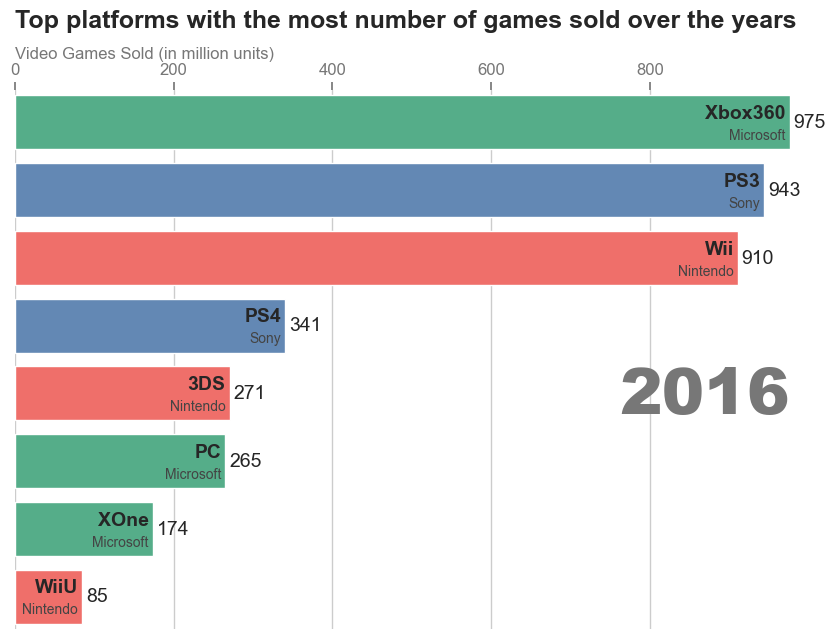

In [32]:
fig, ax = plt.subplots(figsize=(10, 7))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1980, 2017), interval=2000)
# Interactive version for the notebook
HTML(animator.to_jshtml())
plt.show()

---

# Best-selling Genres of the Decade

In [33]:
# Create decade column
df['Decade'] = ((np.floor(df['Year_of_Release'] / 10) * 10).astype(int))
df.head()

Name Platform  Year_of_Release         Genre Publisher  \
0                Wii Sports      Wii             2006        Sports  Nintendo   
1         Super Mario Bros.      NES             1985    Platformer  Nintendo   
2            Mario Kart Wii      Wii             2008        Racing  Nintendo   
3         Wii Sports Resort      Wii             2009        Sports  Nintendo   
4  Pokemon Red/Pokemon Blue  GameBoy             1996  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  \
0     41.36     28.96      3.77         8.45         82.54   
1     29.08      3.58      6.81         0.77         40.24   
2     15.68     12.80      3.79         3.29         35.57   
3     15.61     10.95      3.28         2.95         32.78   
4     11.27      8.89     10.22         1.00         31.37   

   Platform_Launch_Year  Decade  
0                  2006    2000  
1                  1983    1980  
2                  2006    2000  
3                  2006    2000  
4                  1989    1990

In [34]:
# Omitting video games released before 1980.
df_copy = df.copy()
df_copy = df_copy.loc[df_copy.Year_of_Release >= 1980]
df_copy.shape

(17389, 12)

In [35]:
# Group by genre and decade
df_genre_of_the_decade = (df_copy
                    .groupby(['Genre', 'Decade'])
                    .Global_Sales
                    .sum()
                    .reset_index())

In [36]:
# Add a column with % of global sales per genre
df_genre_of_the_decade['Decade_Global_Sales'] = df_genre_of_the_decade.groupby('Decade').Global_Sales.transform('sum')
df_genre_of_the_decade['%Global_Sales'] = (df_genre_of_the_decade['Global_Sales'] / df_genre_of_the_decade['Decade_Global_Sales']).mul(100).round(2)
df_genre_of_the_decade.head()

Genre  Decade  Global_Sales  Decade_Global_Sales  %Global_Sales
0     Action    1980         51.88               379.43          13.67
1     Action    1990        140.69              1284.53          10.95
2     Action    2000        868.73              4687.15          18.53
3     Action    2010        698.52              2636.72          26.49
4  Adventure    1980          6.08               379.43           1.60

In [37]:
# 3 most popular genres in each decade
popular_genres = set()
for i in [1980, 1990, 2000, 2010]:
    a, b, c = df_genre_of_the_decade[df_genre_of_the_decade['Decade'] == i].sort_values('%Global_Sales', ascending=False)['Genre'].head(3)
    popular_genres.add(a)
    popular_genres.add(b)
    popular_genres.add(c)
popular_genres

{'Action',
 'Misc',
 'Platformer',
 'Puzzle',
 'Racing',
 'Role-Playing',
 'Shooter',
 'Sports'}

In [38]:
# Filter data with the list of popular genres
dff = df_genre_of_the_decade[df_genre_of_the_decade['Genre'].isin(popular_genres)]

In [39]:
# Plot using barplot
fig, ax = plt.subplots()

sns_plot = sns.barplot(data=dff, x='Decade', y='%Global_Sales', hue='Genre')
ax.set_xticklabels(['80s', '90s', '00s', '10s'])
ax.set(xlabel="Decade", ylabel="% Sales", title="Most popular genre per decade")

[Text(0, 0, '80s'), Text(1, 0, '90s'), Text(2, 0, '00s'), Text(3, 0, '10s')]

[Text(0.5, 0, 'Decade'),
 Text(0, 0.5, '% Sales'),
 Text(0.5, 1.0, 'Most popular genre per decade')]

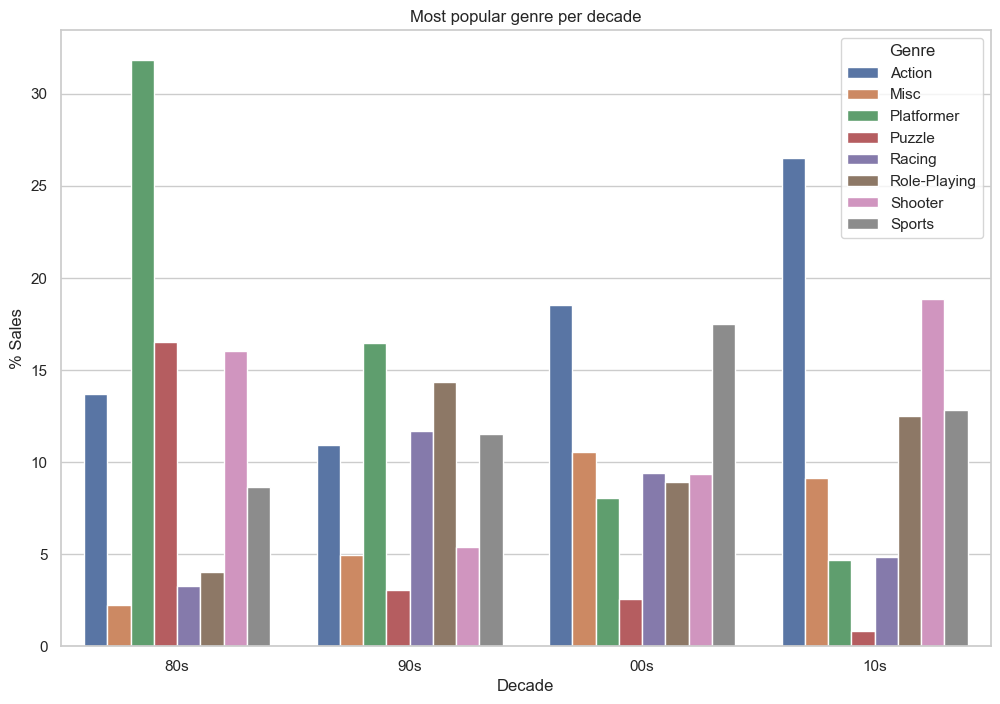

In [40]:
plt.show()

---

# Examining Trends in Video Games Sales History
Simple linear regression has been used to fit a line to the data to explore basic increasing/decreasing trends.

## Determining Usable Years 

Video game sales before a certain point in time would not be very relevant for our visualizations because not all genres of video games are represented in the data until a certain point in time. To determine the starting year, two things should be considered: the yearly global sales and at what point in time were all genres being continuously released. Fortunately, a starting year can be chosen by looking at the total yearly global sales, the cumulative proportion of yearly global sales and the heat map of global sales of games released each year by genre. 

Using the following three plots below the following can be seen:

1. All genres are not fully represented until the year 1991.

2. More than 95% of the global sales occur after 1991. 

Hence we will start by only considering the video game sales from 1991 to 2016.

<AxesSubplot:xlabel='Year_of_Release'>

Text(0.5, 1.0, 'Total Yearly Global Sales')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of games sold (in millions)')

<AxesSubplot:xlabel='Year_of_Release'>

Text(0.5, 1.0, 'Cumulative Proportions of Yearly Global Sales')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Cummulative Proportion')

<AxesSubplot:xlabel='Genre', ylabel='Year_of_Release'>

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(97.12499999999999, 0.5, 'Year of Release')

Text(0.5, 55.242133888671546, 'Genre of Video Games')

Text(0.5, 1.0, 'Global Sales (in millions) of Games Released Each Year by Genre')

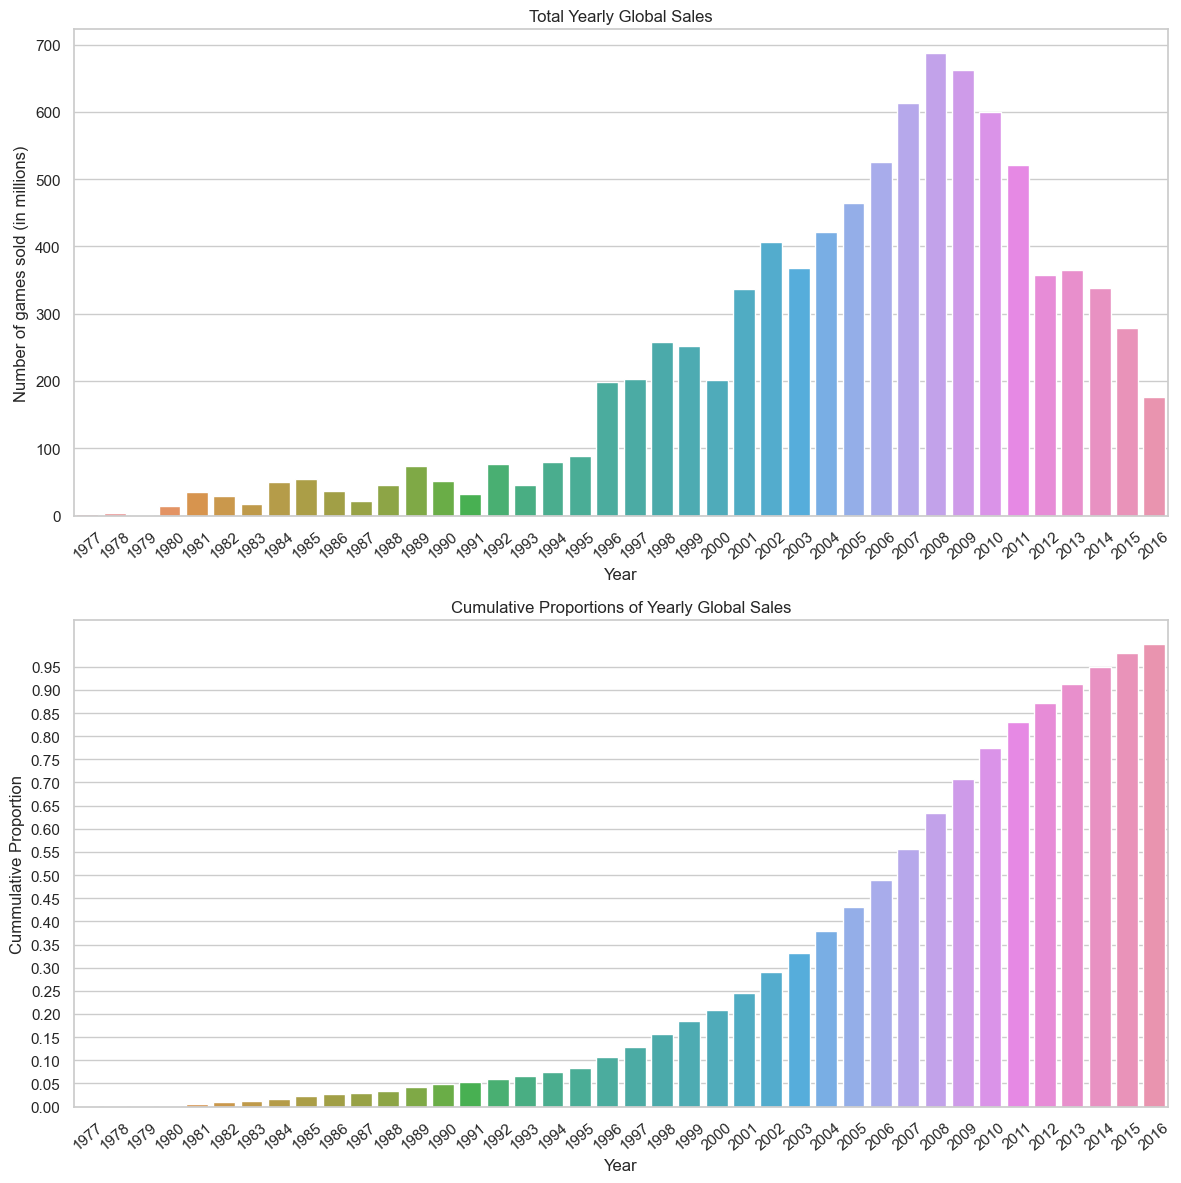

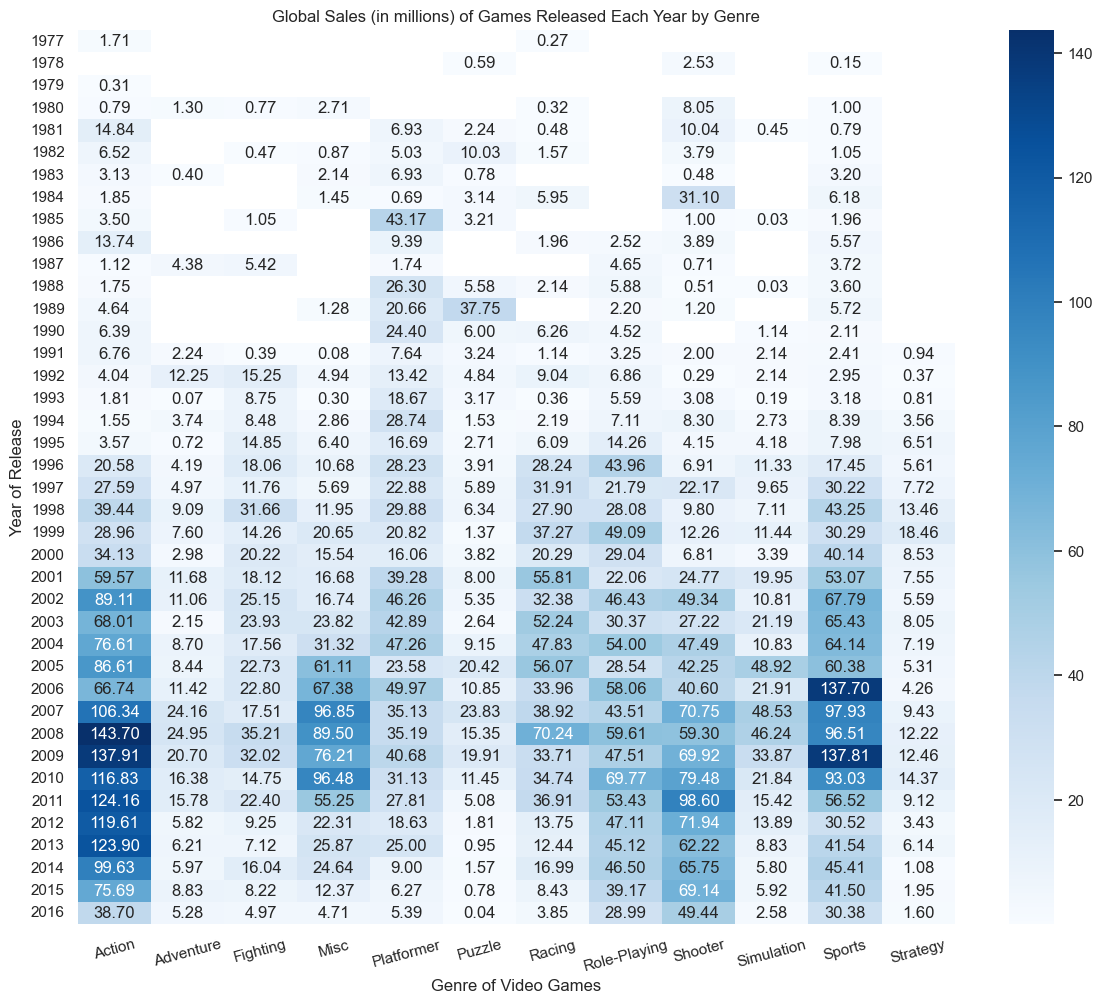

In [41]:
# Creating a table of the total global sales for each genre and year
Sales_by_Gen_and_Yr = pd.pivot_table(df, index=['Year_of_Release'],
                     columns=['Genre'], values=['Global_Sales'], aggfunc=np.sum)
Sales_by_Gen_and_Yr.columns = Sales_by_Gen_and_Yr.columns.get_level_values(1)

# Finding the yearly totals and cumulative proportion of yearly global sales
Yearly_Tots = Sales_by_Gen_and_Yr.sum(axis=1)
Yearly_Tots = Yearly_Tots.sort_index()
YT1_cumsum = Yearly_Tots.cumsum()/Yearly_Tots.sum()

# Plotting the yearly totals and cumulative proportions
fig, axs = plt.subplots(2, 1, figsize=(12,12))
#ax1=fig.add_subplot(121)
#ax2=fig.add_subplot(122)
sns.barplot(y = Yearly_Tots.values, x = Yearly_Tots.index,ax=axs[0])
axs[0].set_title('Total Yearly Global Sales')
plt.setp(axs[0].get_xticklabels(),rotation=40)
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of games sold (in millions)')

sns.barplot(y = YT1_cumsum.values, x = YT1_cumsum.index, ax=axs[1])
axs[1].set_title('Cumulative Proportions of Yearly Global Sales')
plt.setp(axs[1].get_xticklabels(),rotation=40)
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Cummulative Proportion')
axs[1].yaxis.set_ticks(np.arange(0,1,0.05))
fig.tight_layout()

# Plotting the heat map of global sales for games released each year by genre
fig2, ax2 = plt.subplots(1, 1, figsize=(12,10))
sns.heatmap(Sales_by_Gen_and_Yr,annot = True, fmt = '.2f', cmap = 'Blues', ax=ax2)
plt.setp(ax2.get_xticklabels(),rotation=15)
plt.tight_layout()
plt.ylabel('Year of Release')
plt.xlabel('Genre of Video Games')
plt.title('Global Sales (in millions) of Games Released Each Year by Genre')
plt.show()

---

In [42]:
# Pulling only the data from 1991 to 2016
data = df.loc[df.Year_of_Release >= 1991]

# Finding the median sales value by genre and year
Med_Sales_by_Gen_and_Yr = pd.pivot_table(data, index=['Year_of_Release'],
                     columns=['Genre'], values=['Global_Sales'], aggfunc=np.median)
Med_Sales_by_Gen_and_Yr.columns = Med_Sales_by_Gen_and_Yr.columns.get_level_values(1)

Med_Sales_by_Gen_and_Yr.head()

Genre            Action  Adventure  Fighting   Misc  Platformer  Puzzle  \
Year_of_Release                                                           
1991              0.420      1.120      0.39  0.080        0.78   0.585   
1992              2.020      0.475      1.66  2.470        1.00   1.120   
1993              0.145      0.070      0.45  0.060        0.56   0.980   
1994              0.050      0.435      0.18  0.050        1.79   0.700   
1995              0.380      0.050      0.23  0.085        0.30   0.175   

Genre            Racing  Role-Playing  Shooter  Simulation  Sports  Strategy  
Year_of_Release                                                               
1991              1.140          0.38     0.23       1.070   0.280     0.215  
1992              4.520          0.97     0.13       2.140   0.370     0.060  
1993              0.180          0.32     1.54       0.190   0.180     0.405  
1994              0.190          0.12     0.33       0.280   0.345     0.310  
1995              0.155          0.34     0.10       0.085   0.190     0.125

## Examining the trend in Global Sales for all genres by plotting the yearly median of all global sales.

In [43]:
Med_Sales_by_Yr = pd.pivot_table(data,index=['Year_of_Release'],
                     values=['Global_Sales'],aggfunc=np.median)


fig = plt.figure(figsize=(13,5))
Med_Sales_by_Yr.plot()

x_data = np.transpose(np.matrix(Med_Sales_by_Yr.index))
y_data = Med_Sales_by_Yr
regr = linear_model.LinearRegression()
regr.fit(x_data,y_data)

plt.plot(x_data,regr.predict(x_data), color='black')

txt = 'Coeff: %.3f \nMSE: %.3f' % (regr.coef_,np.mean((regr.predict(x_data)-y_data)**2))

plt.text(2011,0.8*Med_Sales_by_Yr.max(),txt)

plt.title('Median Global Sales')
plt.xlabel('Year')
plt.ylabel('Median Sales (in million units)')

<AxesSubplot:xlabel='Year_of_Release'>

LinearRegression()

Text(2011, Global_Sales    0.548
dtype: float64, 'Coeff: -0.012 \nMSE: 0.007')

Text(0.5, 1.0, 'Median Global Sales')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Median Sales (in million units)')

<Figure size 1300x500 with 0 Axes>

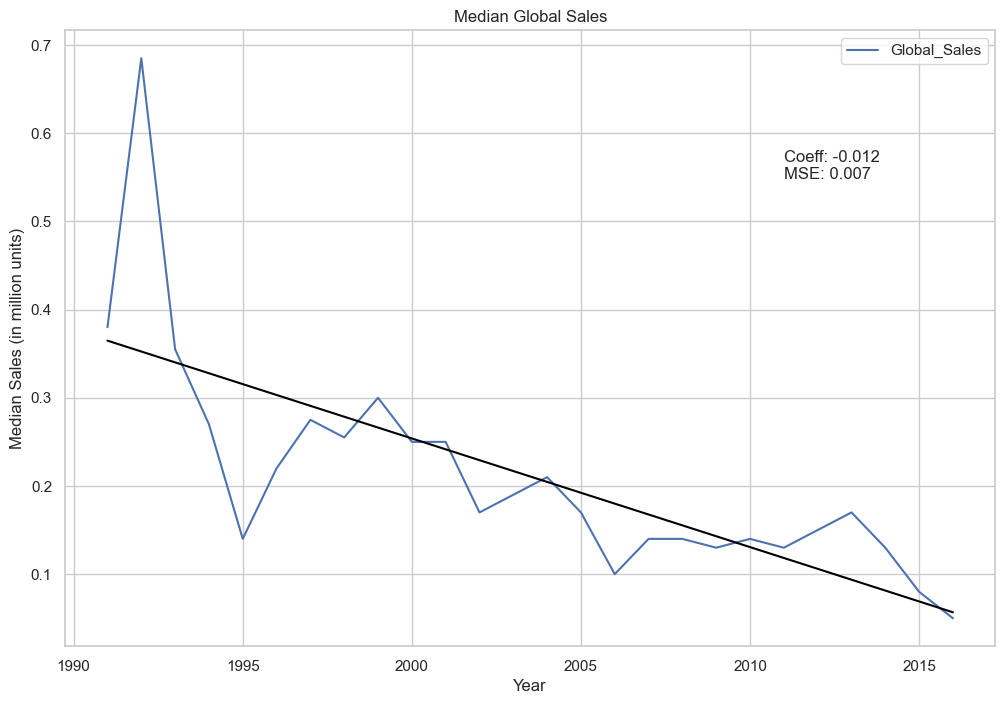

In [44]:
plt.show()

From the plot above we can see that there is an overall decline in global sales of video games. 

Now let us examing the sales for each genre and see if there is any increase or decline in the same.

## Examining the trend in Sales for each genre and see if there is any increase or decline in the same.

In [45]:
def Linear_Regression_Plot(Data):
    Regr_Coeff = []
    Regr_MSE = []
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,12))

    x_data = np.transpose(np.matrix(Data.index))

    count = 0
    
    for genre in Data.columns:
        axs = axes[count//3,count%3]
        y_data = Data[genre].to_frame()
    
        # Linear regression
        regr = linear_model.LinearRegression()
        regr.fit(x_data,y_data)
        
        # Mean Squared Error
        MSE = np.mean((regr.predict(x_data)-y_data)**2)
        
        Regr_Coeff.append(regr.coef_[0][0])
        Regr_MSE.append(MSE[0])

        Data[genre].plot(ax=axs)
        axs.plot(x_data,regr.predict(x_data), color='black')

        y_lims = axs.get_ylim()
        
        
        txt = 'Coeff: %.3f \nMSE: %.3f' % (regr.coef_,MSE)
        y_loc = 0.85*(y_lims[1]-y_lims[0])+y_lims[0]
        axs.text(2007,y_loc,txt)

        axs.set_title(genre)
        axs.set_xlabel('Year')
        axs.set_ylabel('Median')
        count+=1
        
    fig.tight_layout()
    
    return [Regr_Coeff, Regr_MSE]

[Regr_Coeff, Regr_MSE] = Linear_Regression_Plot(Med_Sales_by_Gen_and_Yr)

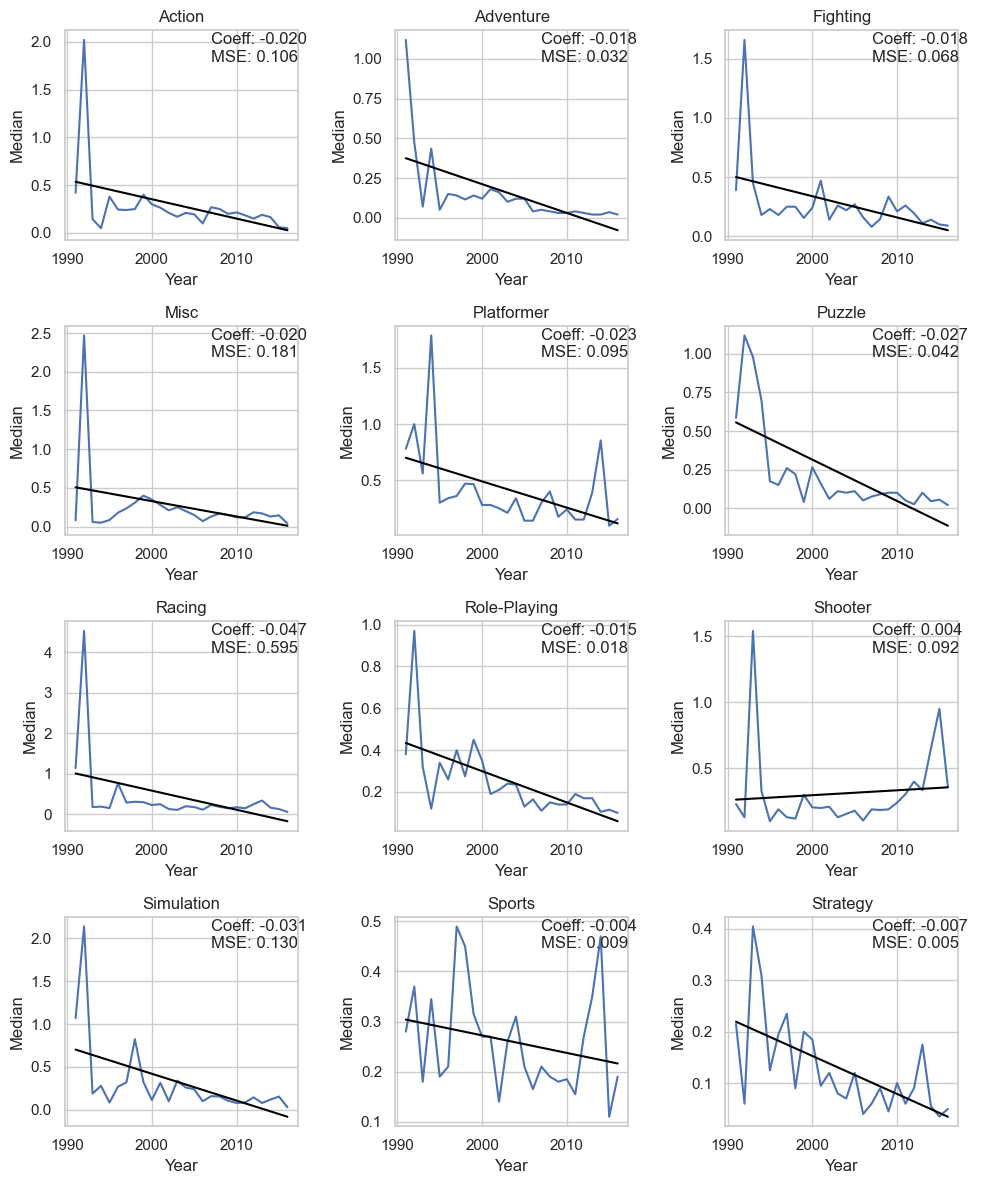

In [46]:
plt.show()

As we can see above, all of the genres except Shooter games have a negative trend in yearly sales.

However, If we notice here, we can see that for many of the genres there is a large spike (an outlier) before 1995. This initial spike in the data is affecting the slope of the trends and is not as relevant to recent sales.Therefore, we can perform the same analysis starting from 1995 and it will still include over 90% of the total cumulative global sales.

In [47]:
Med_Sales_by_Gen_and_Yr = Med_Sales_by_Gen_and_Yr.loc[Med_Sales_by_Gen_and_Yr.index >= 1995]
[Regr_Coeff_After_95, Regr_MSE_After_95] = Linear_Regression_Plot(Med_Sales_by_Gen_and_Yr)

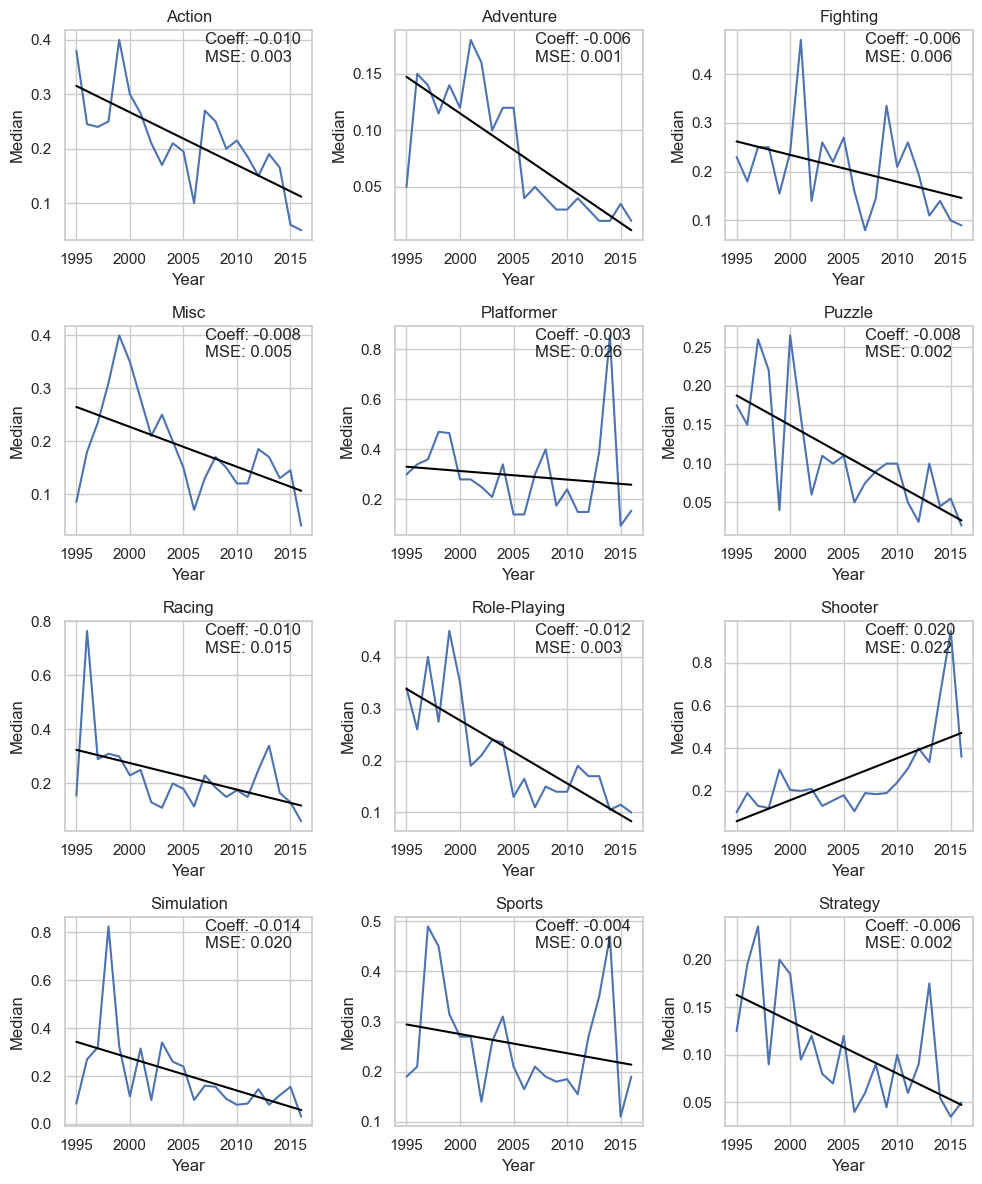

In [48]:
plt.show()

## Conclusion

After excluding the years before 1995 the trends are generally the same; however the severity of the decline in all but the Sports genre lessened. 

Looking at the median values, of all the declining genres Simulation, Role-Playing, Racing, and Action games have incurred the steepest decline in sales.

In [49]:
Linear_Regression_Results = pd.DataFrame({'Regression Coeff After 1991':Regr_Coeff,
                                         'MSE After 1991':Regr_MSE,
                                         'Regression Coeff After 1995':Regr_Coeff_After_95,
                                         'MSE After 1995':Regr_MSE_After_95},
                                        index = list(Med_Sales_by_Gen_and_Yr.columns))
Column_Order = ['Regression Coeff After 1991','MSE After 1991','Regression Coeff After 1995',
                'MSE After 1995']

# Printing the linear regression results
Linear_Regression_Results[Column_Order].head(n=len(list(Med_Sales_by_Gen_and_Yr.columns)))

Regression Coeff After 1991  MSE After 1991  \
Action                          -0.020282        0.106425   
Adventure                       -0.018154        0.031658   
Fighting                        -0.017986        0.068396   
Misc                            -0.019853        0.181360   
Platformer                      -0.023383        0.095485   
Puzzle                          -0.026802        0.041777   
Racing                          -0.047101        0.595477   
Role-Playing                    -0.014969        0.018061   
Shooter                          0.003713        0.092050   
Simulation                      -0.031340        0.129551   
Sports                          -0.003506        0.009475   
Strategy                        -0.007397        0.004790   

              Regression Coeff After 1995  MSE After 1995  
Action                          -0.009695        0.003197  
Adventure                       -0.006460        0.001132  
Fighting                        -0.005517        0.006490  
Misc                            -0.007549        0.005385  
Platformer                      -0.003425        0.025815  
Puzzle                          -0.007662        0.002454  
Racing                          -0.009825        0.015206  
Role-Playing                    -0.012149        0.003442  
Shooter                          0.019701        0.021505  
Simulation                      -0.013569        0.019819  
Sports                          -0.003823        0.010204  
Strategy                        -0.005503        0.002014

With the exception of the Shooter genre of video games, the global sales for all other video game genres have been declining. This could be due to the increase in games being played on tablets and smart phones. 

First person shooter games are not easily playable on touchscreen controls causing them to be unaffected by the increase in popularity of using tablets and smart phones as a gaming platform. 

Another significant factor in the rise of sales for Shooter games could be the explosive growth in multiplayer games that can be played online with friends and are predominantly from the Shooter genre.    

# Word Cloud - a fun visualization to conclude the report.

In [50]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [51]:
wave_mask= np.array(Image.open("Game Controller Card.png"))
stopwords = set(STOPWORDS)
stopwords.update(["II", "III"])
plt.subplots(figsize=(15,15))
wordcloud = WordCloud(mask=wave_mask,background_color="lavenderblush",colormap="hsv" ,contour_width=2, contour_color="black",
                      width=950,stopwords=stopwords,
                          height=950
                         ).generate(" ".join(df.Name))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.savefig('graph.png')

#plt.show()

(<Figure size 1500x1500 with 1 Axes>, <AxesSubplot:>)

(-0.5, 981.5, 657.5, -0.5)

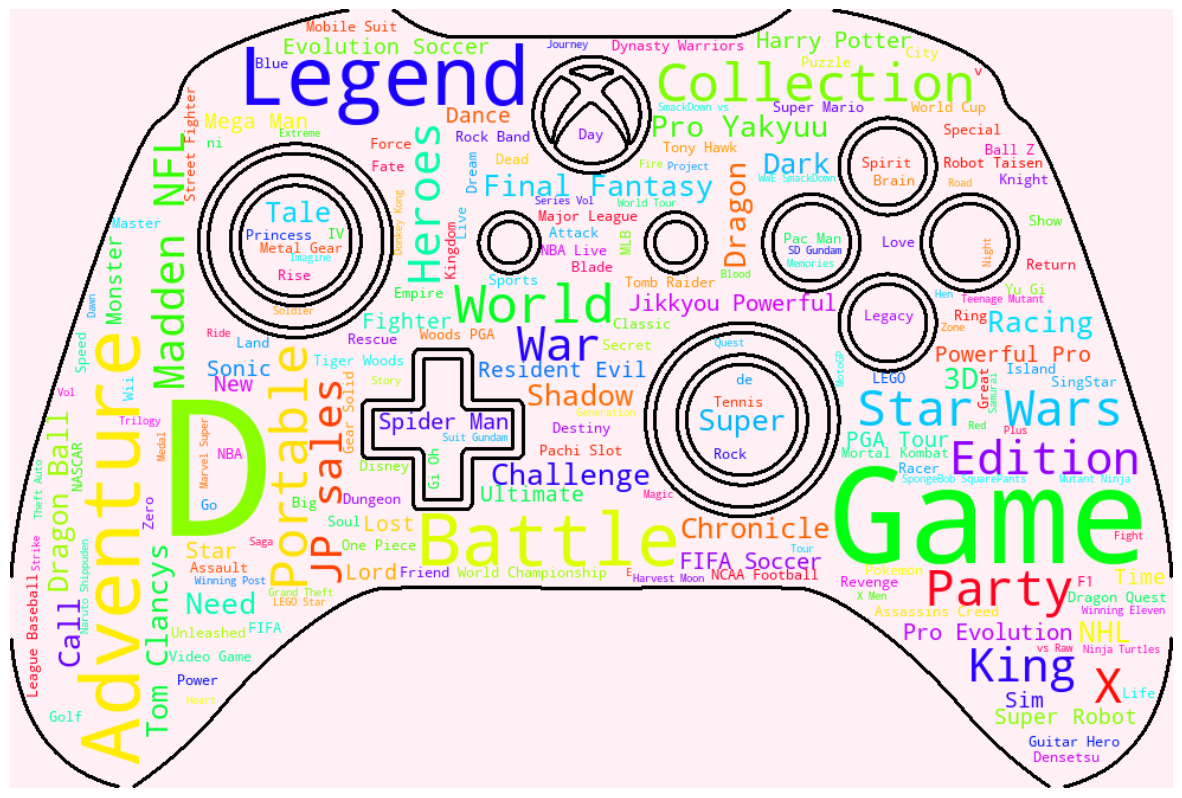

In [52]:
plt.show()